In [1]:
import pandas as pd
import os
import numpy as np
import requests
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import time
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import openmeteo_requests
import requests_cache
from retry_requests import retry
import hsfs
from pathlib import Path
from dotenv import load_dotenv
import hopsworks
import sys

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from format_data import format_weather_data, format_price_data, merge_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from format_data import format_weather_data, format_price_data, process_weather_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast
from entsoe_data import fetch_historical_data, ensure_valid_series

In [2]:
load_dotenv()
hopsworks_api = os.getenv("HOPSWORKS_API_KEY")

os.environ["HOPSWORKS_API_KEY"] = hopsworks_api

project = hopsworks.login()

print(f"Connected to project: {project.name}")

2025-01-06 11:22:11,998 INFO: Initializing external client
2025-01-06 11:22:12,001 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 11:22:14,135 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164446
Connected to project: oskaralf


In [3]:
def get_feature_group_as_dataframe(project_name, feature_group_name, version=1):
    fs = project.get_feature_store()
    feature_group = fs.get_feature_group(name=feature_group_name, version=version)
    df = feature_group.read()
    return df

In [4]:
fs = project.get_feature_store()

In [6]:
#price_df = get_feature_group_as_dataframe(project.name, "electricity_price_data")
weather_df = get_feature_group_as_dataframe(project.name, "weather_data_3")
entsoe_df = get_feature_group_as_dataframe(project.name, "entsoe_data_3")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.34s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


In [9]:
print(entsoe_df.columns)
entsoe_df = entsoe_df.sort_values(by='date')
weather_df = weather_df.sort_values(by='date')

Index(['load_se3', 'load_finland', 'load_norway', 'load_denmark', 'prices',
       'total_generation_biomass', 'total_generation_fossil_gas',
       'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
       'total_generation_hydro_run_of_river_and_poundage',
       'total_generation_other_renewable', 'total_generation_solar',
       'total_generation_waste', 'total_generation_wind_offshore',
       'total_generation_wind_onshore', 'flows_se3_to_finland',
       'flows_finland_to_se3', 'flows_se3_to_norway', 'flows_norway_to_se3',
       'flows_se3_to_denmark', 'flows_denmark_to_se3', 'date'],
      dtype='object')


In [10]:
print(weather_df['date'].tail(1))
print(entsoe_df['date'].tail(1))

4857   2024-12-31 23:00:00+00:00
Name: date, dtype: datetime64[us, Etc/UTC]
11502   2025-01-05 23:00:00+00:00
Name: date, dtype: datetime64[us, Etc/UTC]


In [8]:
# weather_df = weather_df.sort_values(by='date')
# entsoe_df = entsoe_df.sort_values(by='date')

entsoe_df['date'] = pd.to_datetime(entsoe_df['date']).dt.tz_convert(None)
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.tz_convert(None)

In [9]:
weather_df = weather_df.sort_values(by='date')
entsoe_df = entsoe_df.sort_values(by='date')

In [11]:
print(weather_df['date'].max())
print(entsoe_df['date'].max())

2024-12-31 23:00:00+00:00
2025-01-05 23:00:00+00:00


In [11]:
print(weather_df['date'].tail(1))
print(entsoe_df['date'].tail(1))

15443   2024-12-30 23:00:00
Name: date, dtype: datetime64[us]
18403   2025-01-04 23:00:00
Name: date, dtype: datetime64[us]


In [12]:
merged_df = pd.merge(weather_df, entsoe_df, on='date', how='inner')
# merged_df = merged_df.sort_values(by='date')

print(merged_df.columns)


Index(['date', 'temperature_2m', 'precipitation', 'snow_depth', 'pressure_msl',
       'cloud_cover', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'city', 'load_se3',
       'load_finland', 'load_norway', 'load_denmark', 'prices',
       'total_generation_biomass', 'total_generation_fossil_gas',
       'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
       'total_generation_hydro_run_of_river_and_poundage',
       'total_generation_other_renewable', 'total_generation_solar',
       'total_generation_waste', 'total_generation_wind_offshore',
       'total_generation_wind_onshore', 'flows_se3_to_finland',
       'flows_finland_to_se3', 'flows_se3_to_norway', 'flows_norway_to_se3',
       'flows_se3_to_denmark', 'flows_denmark_to_se3'],
      dtype='object')


In [13]:
print(merged_df.columns)

Index(['date', 'temperature_2m', 'precipitation', 'snow_depth', 'pressure_msl',
       'cloud_cover', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'city', 'load_se3',
       'load_finland', 'load_norway', 'load_denmark', 'prices',
       'total_generation_biomass', 'total_generation_fossil_gas',
       'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
       'total_generation_hydro_run_of_river_and_poundage',
       'total_generation_other_renewable', 'total_generation_solar',
       'total_generation_waste', 'total_generation_wind_offshore',
       'total_generation_wind_onshore', 'flows_se3_to_finland',
       'flows_finland_to_se3', 'flows_se3_to_norway', 'flows_norway_to_se3',
       'flows_se3_to_denmark', 'flows_denmark_to_se3'],
      dtype='object')


In [14]:
merged_df = merged_df.drop(columns=['wind_speed_10m', 'pressure_msl', 'cloud_cover', 'city', 'snow_depth', 'wind_direction_10m', 'wind_direction_100m'])

In [15]:
print(merged_df.columns)

Index(['date', 'temperature_2m', 'precipitation', 'wind_speed_100m',
       'load_se3', 'load_finland', 'load_norway', 'load_denmark', 'prices',
       'total_generation_biomass', 'total_generation_fossil_gas',
       'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
       'total_generation_hydro_run_of_river_and_poundage',
       'total_generation_other_renewable', 'total_generation_solar',
       'total_generation_waste', 'total_generation_wind_offshore',
       'total_generation_wind_onshore', 'flows_se3_to_finland',
       'flows_finland_to_se3', 'flows_se3_to_norway', 'flows_norway_to_se3',
       'flows_se3_to_denmark', 'flows_denmark_to_se3'],
      dtype='object')


In [16]:
merged_df['total_generation_se'] = merged_df[
    [
        'total_generation_biomass', 'total_generation_fossil_gas',
        'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
        'total_generation_hydro_run_of_river_and_poundage',
        'total_generation_other_renewable', 'total_generation_solar',
        'total_generation_waste', 'total_generation_wind_offshore',
        'total_generation_wind_onshore'
    ]
].sum(axis=1)

merged_df = merged_df.drop(columns=    [
        'total_generation_biomass', 'total_generation_fossil_gas',
        'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
        'total_generation_hydro_run_of_river_and_poundage',
        'total_generation_other_renewable', 'total_generation_solar',
        'total_generation_waste', 'total_generation_wind_offshore',
        'total_generation_wind_onshore'
    ])


In [17]:
print(merged_df.columns)

Index(['date', 'temperature_2m', 'precipitation', 'wind_speed_100m',
       'load_se3', 'load_finland', 'load_norway', 'load_denmark', 'prices',
       'flows_se3_to_finland', 'flows_finland_to_se3', 'flows_se3_to_norway',
       'flows_norway_to_se3', 'flows_se3_to_denmark', 'flows_denmark_to_se3',
       'total_generation_se'],
      dtype='object')


In [18]:
merged_df['total_load_abroad'] = merged_df[['load_finland', 'load_norway', 'load_denmark']].sum(axis=1)
merged_df = merged_df.drop(columns=['load_finland', 'load_norway', 'load_denmark'])

In [19]:
print(merged_df.columns)

Index(['date', 'temperature_2m', 'precipitation', 'wind_speed_100m',
       'load_se3', 'prices', 'flows_se3_to_finland', 'flows_finland_to_se3',
       'flows_se3_to_norway', 'flows_norway_to_se3', 'flows_se3_to_denmark',
       'flows_denmark_to_se3', 'total_generation_se', 'total_load_abroad'],
      dtype='object')


In [20]:
columns_to_merge = [
    'flows_se3_to_finland', 'flows_finland_to_se3',
    'flows_se3_to_norway', 'flows_norway_to_se3',
    'flows_se3_to_denmark', 'flows_denmark_to_se3'
]

merged_df['imported_energy'] = merged_df.apply(
    lambda row: sum(-row[col] if 'se3_to' in col else row[col] for col in columns_to_merge),
    axis=1
)

merged_df = merged_df.drop(columns=columns_to_merge)

In [21]:
print(merged_df.columns)

Index(['date', 'temperature_2m', 'precipitation', 'wind_speed_100m',
       'load_se3', 'prices', 'total_generation_se', 'total_load_abroad',
       'imported_energy'],
      dtype='object')


In [23]:
print(merged_df.columns)

Index(['date', 'temperature_2m', 'precipitation', 'wind_speed_100m',
       'load_se3', 'prices', 'total_generation_se', 'total_load_abroad',
       'imported_energy'],
      dtype='object')


In [24]:
print(merged_df.tail(1))

                     date  temperature_2m  precipitation  wind_speed_100m  \
18474 2024-12-30 23:00:00          -1.785            0.0        20.438522   

       load_se3  prices  total_generation_se  total_load_abroad  \
18474   10482.0   35.66               2738.0           18020.75   

       imported_energy  
18474          -1473.0  


In [11]:
# price_fg = fs.get_feature_group(
#     name='electricity_price_data_3',
#     version=1,
# )
weather_fg = fs.get_feature_group(
    name='weather_data_3',
    version=1,
)

entsoe_fg = fs.get_feature_group(
    name='entsoe_data_3',
    version=1,
)

In [66]:
df_e = entsoe_fg.read()
df_w = weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.59s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 


In [67]:
m = pd.merge(df_w, df_e, on='date', how='inner')
print(m['date'].isna().sum())

0


In [14]:
if type(df_e['date'].iloc[-1]) == type(df_w['date'].iloc[-1]):
    print("Dates are the same type")

Dates are the same type


In [15]:

print(df_e['date'].tail(1))

19122   2023-03-11 22:00:00+00:00
Name: date, dtype: datetime64[us, Etc/UTC]


In [16]:
print(df_w.dtypes)
print(df_w['date'].tail(1))

date                   datetime64[us, Etc/UTC]
temperature_2m                         float32
precipitation                          float32
snow_depth                             float32
pressure_msl                           float32
cloud_cover                            float32
wind_speed_10m                         float32
wind_speed_100m                        float32
wind_direction_10m                     float32
wind_direction_100m                    float32
city                                    object
dtype: object
18503   2023-03-11 22:00:00+00:00
Name: date, dtype: datetime64[us, Etc/UTC]


In [28]:
df_e['date'] = pd.to_datetime(df_e['date']).dt.tz_localize(None)
df_w['date'] = pd.to_datetime(df_w['date']).dt.tz_localize(None)

print(df_w['date'].tail(1))

print(df_e['date'].tail(1))

18647   2025-01-11 12:00:00
Name: date, dtype: datetime64[us]
19117   2025-01-05 04:00:00
Name: date, dtype: datetime64[us]


In [12]:



# Define the columns to be selected
columns = [
    'load_se3', 'load_finland', 'load_norway', 'load_denmark', 'prices',
    'total_generation_biomass', 'total_generation_fossil_gas',
    'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
    'total_generation_hydro_run_of_river_and_poundage',
    'total_generation_other_renewable', 'total_generation_solar',
    'total_generation_waste', 'total_generation_wind_offshore',
    'total_generation_wind_onshore', 'flows_se3_to_finland',
    'flows_finland_to_se3', 'flows_se3_to_norway', 'flows_norway_to_se3',
    'flows_se3_to_denmark', 'flows_denmark_to_se3'
]

# Select the specified columns from entsoe_fg and join with all columns from weather_fg
#entsoe_query = entsoe_fg.select(columns)
#weather_query = weather_fg.select_all()
selected_features = entsoe_fg.select(columns).join(weather_fg.select_all(), on=['date'], join_type='inner')
#selected_features = entsoe_query.join(weather_query, on=['date'])



# Show the first 10 rows of the feature view to verify
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.42s) 


,load_se3,load_finland,load_norway,load_denmark,prices,total_generation_biomass,total_generation_fossil_gas,total_generation_fossil_hard_coal,total_generation_fossil_oil,total_generation_hydro_run_of_river_and_poundage,...,temperature_2m,precipitation,snow_depth,pressure_msl,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,city
0,7471.0,8027.0,2865.0,2000.0,37.00,166.0,115.0,37.0,7.0,1.0,...,8.565000,0.0,0.0,1017.099976,100.0,8.759178,17.283749,260.537750,268.806549,Stockhom
1,9563.0,9191.0,3937.0,2716.0,77.99,176.0,114.0,39.0,7.0,1.0,...,8.264999,0.0,0.0,1017.099976,100.0,9.255571,16.516901,283.495758,286.460083,Stockhom
2,9782.0,9532.0,3882.0,2827.0,91.30,126.0,138.0,323.0,9.0,1.0,...,9.365000,0.0,0.0,1010.900024,100.0,11.367109,22.682856,169.045975,180.909363,Stockhom
3,7604.0,7973.0,3016.0,2174.0,40.21,115.0,89.0,106.0,8.0,1.0,...,6.115000,0.0,0.0,1013.099976,85.0,10.587918,21.933426,234.688705,246.801376,Stockhom
4,9011.0,9229.0,3549.0,2623.0,76.00,129.0,132.0,113.0,9.0,1.0,...,7.465000,0.0,0.0,1013.799988,100.0,7.771331,15.021105,193.392517,224.029068,Stockhom
5,9445.0,9620.0,3950.0,2908.0,100.02,123.0,134.0,156.0,14.0,1.0,...,8.115000,0.0,0.0,1012.799988,100.0,14.882420,29.142216,147.847733,152.801956,Stockhom
6,9919.0,9701.0,4099.0,2762.0,240.55,156.0,263.0,252.0,14.0,1.0,...,8.065000,0.0,0.0,1012.700012,100.0,18.089775,32.839027,132.580460,135.444092,Stockhom
7,7970.0,8687.0,3137.0,2102.0,129.04,213.0,197.0,71.0,14.0,1.0,...,8.415000,0.0,0.0,1010.799988,100.0,17.102840,29.964457,139.267990,144.782318,Stockhom
8,9083.0,9102.0,3674.0,2210.0,114.45,259.0,214.0,84.0,16.0,1.0,...,7.365000,1.5,0.0,1009.500000,100.0,15.815435,29.379175,138.691483,143.972534,Stockhom
9,8934.0,9134.0,3623.0,2137.0,88.72,261.0,157.0,59.0,11.0,1.0,...,7.415000,0.5,0.0,1008.500000,100.0,15.349684,28.555965,140.710602,146.309906,Stockhom


In [27]:

# selected_features = entsoe_fg.select(['prices']).join(weather_fg.select_all(), on=['date'])
# selected_features.show(10)

In [13]:
feature_view = fs.get_or_create_feature_view(
    name='electricity_price_fv_3',
    description="weather + entose features with electricity prices as the target",
    version=1,
    labels=['prices'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164446/fs/1155149/fv/electricity_price_fv_3/version/1


In [8]:
feature_view_df = feature_view.get_batch_data()
print(feature_view_df.isna().sum())
#print(feature_view_df.columns)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.73s) 
load_se3                                            0
load_finland                                        0
load_norway                                         0
load_denmark                                        0
total_generation_biomass                            0
total_generation_fossil_gas                         0
total_generation_fossil_hard_coal                   0
total_generation_fossil_oil                         0
total_generation_hydro_run_of_river_and_poundage    0
total_generation_other_renewable                    0
total_generation_solar                              0
total_generation_waste                              0
total_generation_wind_offshore                      0
total_generation_wind_onshore                       0
flows_se3_to_finland                                0
flows_finland_to_se3                                0
flows_se3_to_norway                               

In [14]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size = 0.2
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.87s) 
2025-01-06 11:34:05,692 WARNING: VersionWarning: Incremented version to `1`.



In [23]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [15]:
print(X_train.columns)
print(y_train.columns)
print(X_test.columns)
print(y_test.columns)

Index(['load_se3', 'load_finland', 'load_norway', 'load_denmark',
       'total_generation_biomass', 'total_generation_fossil_gas',
       'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
       'total_generation_hydro_run_of_river_and_poundage',
       'total_generation_other_renewable', 'total_generation_solar',
       'total_generation_waste', 'total_generation_wind_offshore',
       'total_generation_wind_onshore', 'flows_se3_to_finland',
       'flows_finland_to_se3', 'flows_se3_to_norway', 'flows_norway_to_se3',
       'flows_se3_to_denmark', 'flows_denmark_to_se3', 'date',
       'temperature_2m', 'precipitation', 'snow_depth', 'pressure_msl',
       'cloud_cover', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'city'],
      dtype='object')
Index(['prices'], dtype='object')
Index(['load_se3', 'load_finland', 'load_norway', 'load_denmark',
       'total_generation_biomass', 'total_generation_fossil_gas',
       'total_

In [16]:
def modify_dataframe(df):
    # Define the columns to be merged for imported_energy
    columns_to_merge = [
        'flows_se3_to_finland', 'flows_finland_to_se3',
        'flows_se3_to_norway', 'flows_norway_to_se3',
        'flows_se3_to_denmark', 'flows_denmark_to_se3'
    ]

    df['imported_energy'] = df.apply(
        lambda row: sum(-row[col] if 'se3_to' in col else row[col] for col in columns_to_merge),
        axis=1
    )

    df = df.drop(columns=columns_to_merge)

    df['total_load'] = ( df['load_finland'] +
        df['load_norway'] + df['load_denmark'] + df['load_se3']
    )

    df = df.drop(columns=['load_finland', 'load_norway', 'load_denmark', 'load_se3'])

    columns_to_sum = [
        'total_generation_biomass', 'total_generation_fossil_gas',
        'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
        'total_generation_hydro_run_of_river_and_poundage',
        'total_generation_other_renewable', 'total_generation_solar',
        'total_generation_waste', 'total_generation_wind_offshore',
        'total_generation_wind_onshore'
    ]

    df['total_generation_se'] = df[columns_to_sum].sum(axis=1)
    df = df.drop(columns=columns_to_sum)

    return df

In [17]:
X_train = modify_dataframe(X_train)
X_test = modify_dataframe(X_test)


In [18]:
print(X_test.columns)

Index(['date', 'temperature_2m', 'precipitation', 'snow_depth', 'pressure_msl',
       'cloud_cover', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'city', 'imported_energy',
       'total_load', 'total_generation_se'],
      dtype='object')


In [19]:
print(X_train.isna().sum())
print(X_test.isna().sum())
print(y_train.isna().sum())
print(y_test.isna().sum())

date                   0
temperature_2m         0
precipitation          0
snow_depth             0
pressure_msl           0
cloud_cover            0
wind_speed_10m         0
wind_speed_100m        0
wind_direction_10m     0
wind_direction_100m    0
city                   0
imported_energy        0
total_load             0
total_generation_se    0
dtype: int64
date                   0
temperature_2m         0
precipitation          0
snow_depth             0
pressure_msl           0
cloud_cover            0
wind_speed_10m         0
wind_speed_100m        0
wind_direction_10m     0
wind_direction_100m    0
city                   0
imported_energy        0
total_load             0
total_generation_se    0
dtype: int64
prices    0
dtype: int64
prices    0
dtype: int64


In [20]:
train_features = X_train.drop(['snow_depth',
       'pressure_msl', 'cloud_cover', 'wind_speed_10m',
       'wind_direction_10m', 'wind_direction_100m', 'city', 'date'], axis=1)
test_features = X_test.drop(['snow_depth',
       'pressure_msl', 'cloud_cover', 'wind_speed_10m',
       'wind_direction_10m', 'wind_direction_100m', 'city', 'date'], axis=1)

In [21]:
print(train_features.columns)
print(test_features.columns)

Index(['temperature_2m', 'precipitation', 'wind_speed_100m', 'imported_energy',
       'total_load', 'total_generation_se'],
      dtype='object')
Index(['temperature_2m', 'precipitation', 'wind_speed_100m', 'imported_energy',
       'total_load', 'total_generation_se'],
      dtype='object')


In [ ]:
# merged_df = merged_df.drop(columns=['date', 'time_start', 'city'])

In [22]:
os.makedirs('model', exist_ok=True)

In [23]:
train_features = train_features.dropna()
train_features

,temperature_2m,precipitation,wind_speed_100m,imported_energy,total_load,total_generation_se
0,8.565000,0.0,17.283749,-2125.0,20363.00,3313.0
1,8.264999,0.0,16.516901,-1354.0,25407.00,3946.0
2,9.365000,0.0,22.682856,-1995.0,26023.00,3295.0
5,8.115000,0.0,29.142216,-2688.0,25923.00,2546.0
8,7.365000,1.5,29.379175,-2005.0,24069.00,2731.0
...,...,...,...,...,...,...
18503,7.015000,0.0,42.567242,-1892.0,27286.25,4326.0
18504,6.265000,0.0,36.201935,-2030.0,28903.00,4912.0
18505,5.165000,0.0,28.715500,-2726.0,24612.25,5044.0
18506,-1.685000,0.9,27.238943,-3487.0,29724.50,5237.0


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# train_features_scaled = scaler.fit_transform(train_features)
# test_features_scaled = scaler.transform(test_features)

# train_features_scaled = pd.DataFrame(train_features_scaled, columns=train_features.columns)
# test_features_scaled = pd.DataFrame(test_features_scaled, columns=test_features.columns)


In [24]:

xgb_regressor = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,  
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=1.0
    )
#xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_regressor.fit(train_features, y_train)

y_pred = xgb_regressor.predict(test_features)

mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)


MSE: 1998.5633484702507
R squared: 0.5959573414688095


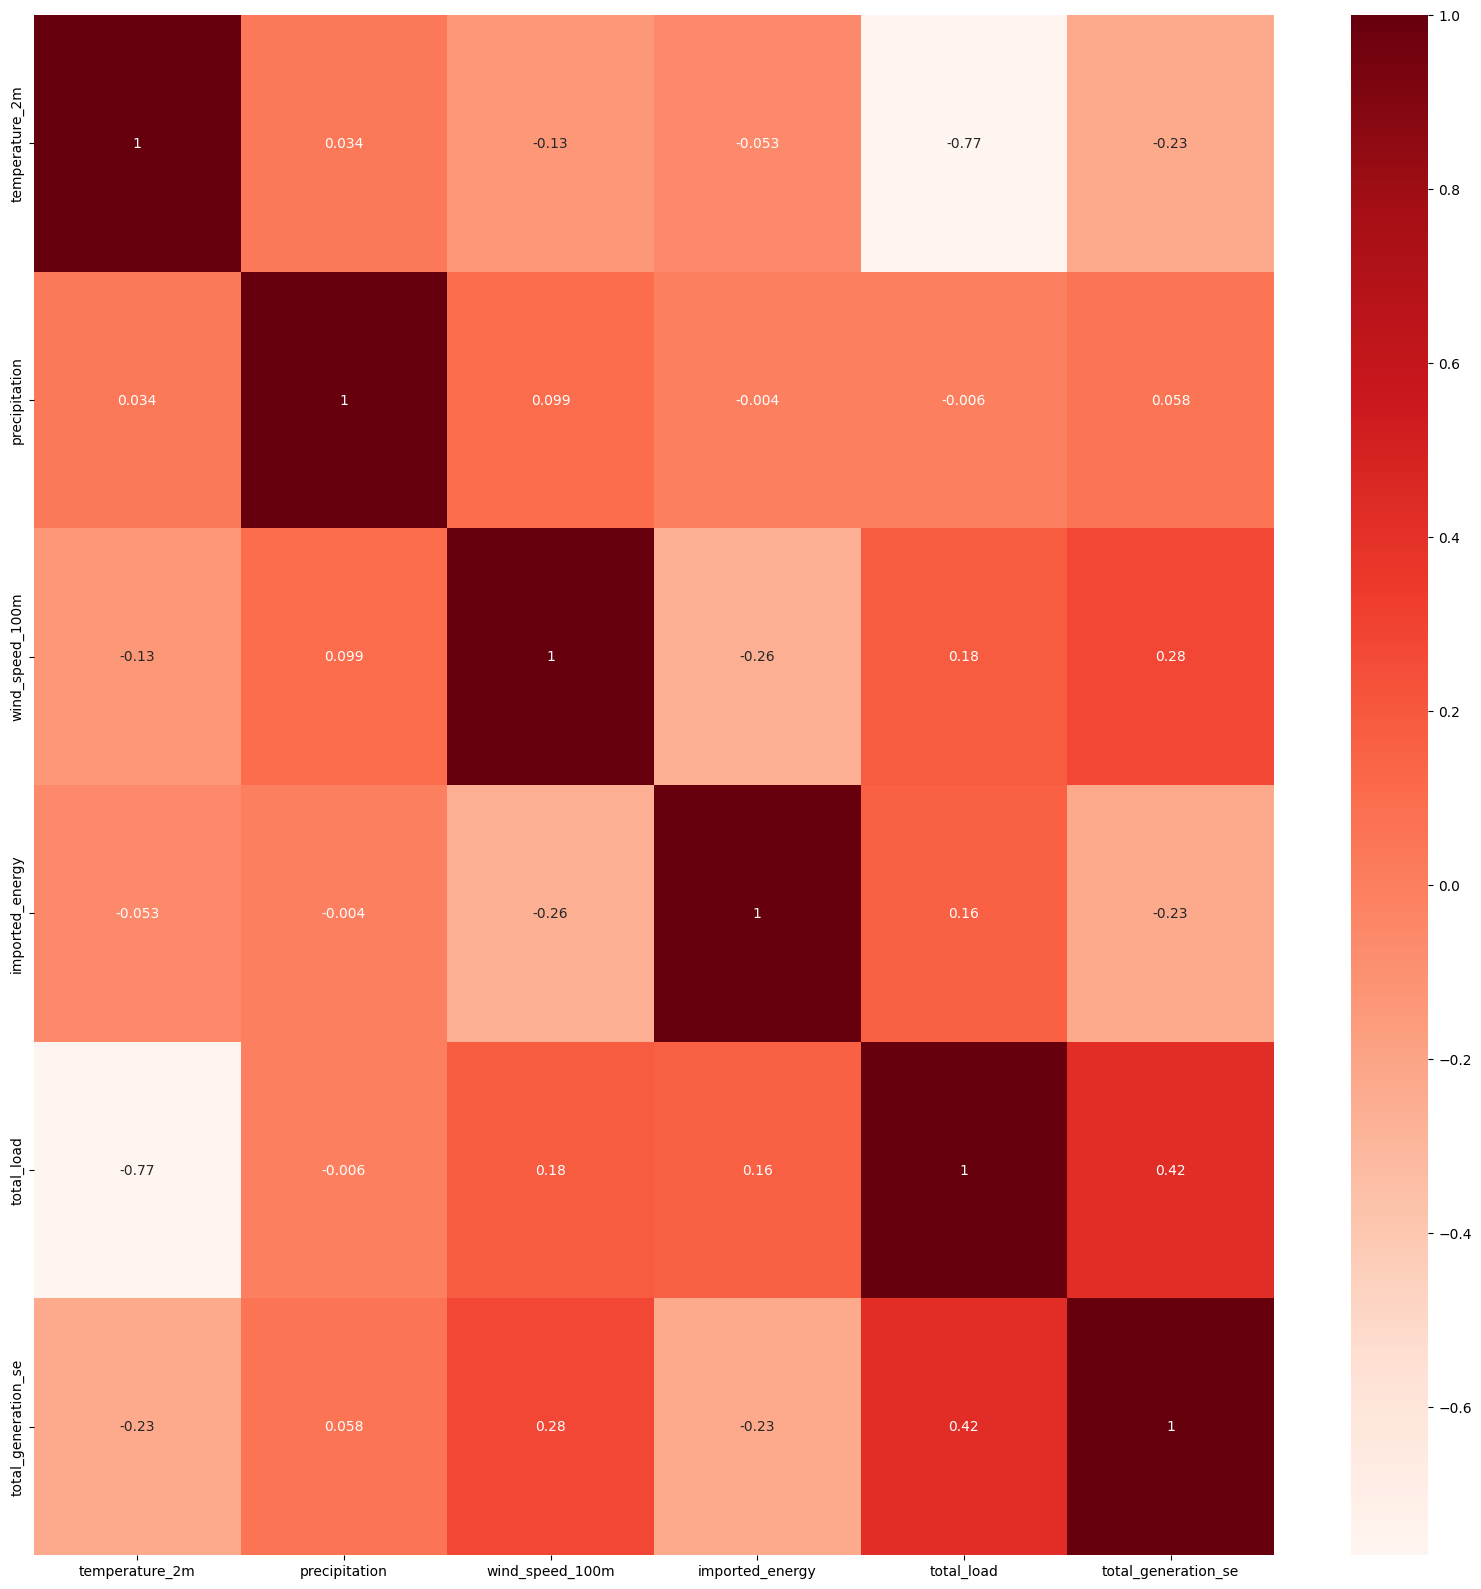

In [26]:
#correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
cor = train_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [27]:
df = y_test
df['predicted_price'] = y_pred

In [28]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,prices,predicted_price,date
8153,38.76,41.505596,2022-11-01 04:00:00+00:00
8154,59.95,48.564217,2022-11-01 06:00:00+00:00
5768,68.89,53.410374,2022-11-01 14:00:00+00:00
11679,15.28,28.780876,2022-11-02 03:00:00+00:00
8156,97.12,63.894238,2022-11-02 08:00:00+00:00


In [29]:
model_dir = "SE3_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [30]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [31]:
xgb_regressor.save_model(model_dir + "/model_se3.json")

In [32]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [33]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

se4_model = mr.python.create_model(
    name="electricity_xgboost_model_se3", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Electricity prices predictor for SE3",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
se4_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/2188081 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/219 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1240 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164446/models/electricity_xgboost_model_se3/1


Model(name: 'electricity_xgboost_model_se3', version: 1)